# シンプルな例: ポケモン3匹

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pathlib
import dotenv
import copy
from matplotlib import pyplot
import seaborn as sns
import japanize_matplotlib
import sklearn.tree

In [2]:
datapath = pathlib.Path('../data') / 'pokemon3' / 'source'
datapath.mkdir(parents=True, exist_ok=True)

In [3]:
response = requests.get('https://ja.wikipedia.org/wiki/%E3%83%9D%E3%82%B1%E3%83%A2%E3%83%B3%E3%81%AE%E4%B8%80%E8%A6%A7_(1-51)')

In [4]:
soup = BeautifulSoup(response.content)

In [5]:
anchors = soup.find_all(class_='mw-headline')

In [6]:
for pokemon in ["フシギダネ", "ヒトカゲ", "ゼニガメ"]:
    anchor = soup.find(id=pokemon)
    name = anchor.get("id")
    texts = []
    for element in anchor.parent.next_siblings:
        if str(element).find("mw-headline") >= 0:
            break
        for t in element.text.split("\n"):
            if len(t):
                texts.append(t)
    json.dump(dict(
        name=name,
        texts=texts,
    ), (datapath / f'{name}.json').open('w+'))


## 質問を生成

In [7]:
data = {
    p.name: json.load(p.open()) for
    p in datapath.iterdir()
}

In [8]:
dotenv.load_dotenv()

True

In [9]:
from typing import List


def filter_first_k_texts(texts: List[str], k):
    """chatGPTに入れるのに長過ぎるので文字列を制限する"""
    retstr = ""
    for text_sepnewline in texts:
        for text in text_sepnewline.split("。"):
            if len(retstr + text) >= k:
                break
            else:
                retstr += ("\n" + text)
    return retstr

In [10]:
data_restricted = {
    key: dict(
        name=datum["name"],
        text=filter_first_k_texts(datum["texts"], 500)  
    ) for key, datum in data.items()
}

In [11]:
data_string = "\n".join([
    f'名前\n"{datum["name"]}"\n\n特徴\n"""{datum["text"]}\n"""\n'
    for datum in data_restricted.values()
])

In [12]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    HumanMessage,
    SystemMessage
)

world = "ポケモン"
system_settings = f'''
{world}についての対話を行います。
{world}の例は以下に示します

{data_string}

上記{world}の設定を参考にして次の対話に答えてください。
では対話を開始します。'''

messages = [
    SystemMessage(content=system_settings),
    HumanMessage(content=f'{world}達を見分けるために最も有効な質問を20個教えて下さい。"はい"/"いいえ"の2択で答えられる質問にしてください。jsonのリストでしゅつりょくしてください。')
]
chat = ChatOpenAI(temperature=0)
response = chat(messages)
print(response.content)

[
  "このポケモンはくさタイプですか？",
  "このポケモンはほのおタイプですか？",
  "このポケモンはみずタイプですか？",
  "このポケモンはどくタイプですか？",
  "このポケモンはかめのこタイプですか？",
  "このポケモンはたねポケモンですか？",
  "このポケモンはとかげポケモンですか？",
  "このポケモンはかめのこポケモンですか？",
  "このポケモンは進化前のポケモンですか？",
  "このポケモンは進化後のポケモンですか？",
  "このポケモンは群れで出現しますか？",
  "このポケモンは野生で出現しますか？",
  "このポケモンは最初に選ぶポケモンの1匹ですか？",
  "このポケモンは最初に貰えるポケモンの1匹ですか？",
  "このポケモンは日光浴を好みますか？",
  "このポケモンは熱いものを好みますか？",
  "このポケモンは背中に大きな種を背負っていますか？",
  "このポケモンは尻尾の先に炎が点っていますか？",
  "このポケモンは首を甲羅の中に引っ込めることができますか？",
  "このポケモンは肉球らしき物が足の裏にありますか？"
]


In [13]:
questions = json.loads(response.content)

## 各ポケモンになりきってすべての質問に回答する

In [14]:
columns = ["質問番号", "質問内容", "回答"]

In [15]:
columns = ["質問内容", "回答"]
json_format = """
{
    "質問内容": <質問内容そのもの>,
    "回答": <質問に対する回答を"はい"か"いいえ"の2択で>   
}
"""
def answer_datum(datum, questions, world):
    system_message = f'''
    このチャットではあなたはjson以外出力しないでください。
    
    あなたが次の{world}になりきってこの後の質問に答えてください。

    フォーマットは以下のjsonです
    """
    {json_format}
    """
    
    あなたがなりきる{world}は以下です。
    名前
    "{datum["name"]}"
    
    特徴
    """
    {datum["text"]}
    """

    それでは質問を行います。
    '''
    human_message = questions
    chat = ChatOpenAI(temperature=0, request_timeout=180)
    responses = []
    for question in questions:
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=f'''
                        次の質問に以下のフォーマットのjsonを返してください。
                        """
                        {json_format}
                        """
                        質問:"{question}"
                         ''')
        ]
        response = chat(messages)
        # print(response.content)
        responses.append(json.loads(response.content))        
    # print(response.content)
    return responses

In [16]:
dumppath = pathlib.Path('../data') / 'pokemon3' / 'qanda'
dumppath.mkdir(exist_ok=True)

In [17]:
data_with_qanda = copy.deepcopy(data)

In [18]:
from tqdm.auto import tqdm
import pandas as pd
import io
ret = {}
for key, datum in tqdm(list(data_restricted.items())):
    if 'qanda' in data_with_qanda[key]:
        print(key)
        continue
    answer = answer_datum(datum=datum, questions=questions, world=world)
    ret[key] = answer
    
    df_qanda = pd.DataFrame(answer).reset_index(names="質問番号")
    # headerline = content.split("\n")[0]

    # # ヘッダーなしで出力されることが有る。。。
    # if headerline == ','.join(columns):
    #     df_qanda = pd.read_csv(io.StringIO(content))
    # else:
    #     df_qanda = pd.read_csv(io.StringIO(content), header=None).set_axis(columns, axis="columns")

    data_with_qanda[key]['qanda'] = df_qanda.to_dict(orient="list")
    json.dump(data_with_qanda[key], (dumppath / key).open("w+"))

/Users/keisuke.ogaki/ghq/github.com/Hi-king/chatgpt_akinator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3/3 [04:03<00:00, 81.07s/it]


## アキネイターにするために決定木を作成

In [19]:
data_with_qanda = {
    p.name: json.load(p.open()) for
    p in dumppath.iterdir()
}

In [20]:
qandamap = pd.concat(
    [
        pd.DataFrame(datum['qanda']).set_index("質問内容")[["回答"]].rename(
            columns={"回答": datum["name"]}
        ).applymap(lambda x: {"はい": 1, "いいえ": -1}[x]) 
        for datum in sorted(data_with_qanda.values(), key=lambda datum: datum["name"])],
    axis=1
)

In [21]:
qandamap.shape

(20, 3)

<Axes: ylabel='質問内容'>

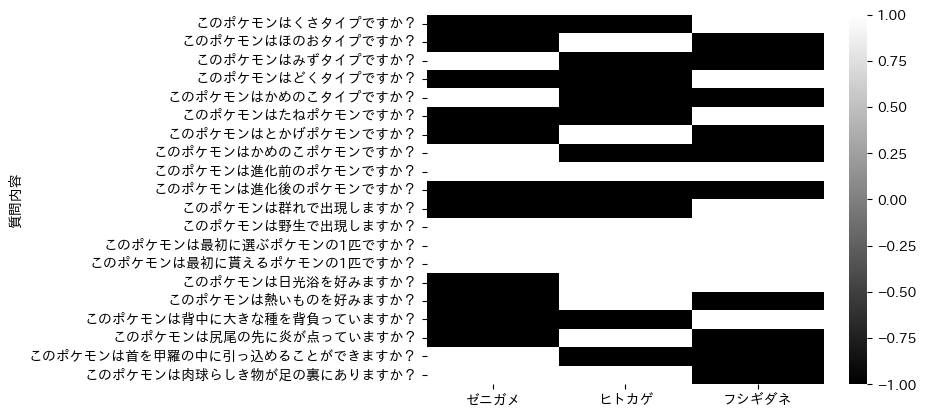

In [22]:
sns.heatmap(qandamap.fillna(0), cmap="gray")

In [23]:
classifier = sklearn.tree.DecisionTreeClassifier()
classifier.fit(qandamap.T, qandamap.columns)

DecisionTreeClassifier()

[Text(0.6, 0.8333333333333334, 'このポケモンはとかげポケモンですか？ <= 0.0\ngini = 0.667\nsamples = 3\nvalue = [1, 1, 1]\nclass = ゼニガメ'),
 Text(0.4, 0.5, 'このポケモンは首を甲羅の中に引っ込めることができますか？ <= 0.0\n0.5\n2\n[1, 0, 1]\nゼニガメ'),
 Text(0.2, 0.16666666666666666, '0.0\n1\n[0, 0, 1]\nフシギダネ'),
 Text(0.6, 0.16666666666666666, '0.0\n1\n[1, 0, 0]\nゼニガメ'),
 Text(0.8, 0.5, '0.0\n1\n[0, 1, 0]\nヒトカゲ')]

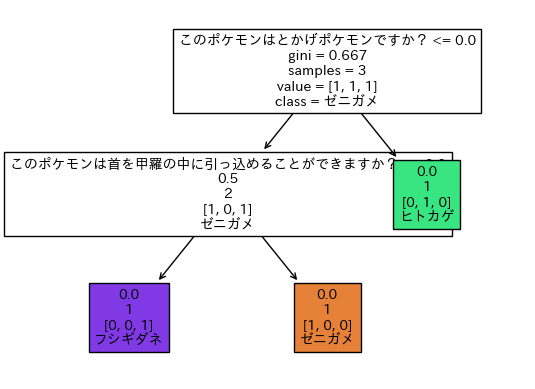

In [24]:
# pyplot.figure(figsize=(50,50)) 
sklearn.tree.plot_tree(
    classifier,
    feature_names=qandamap.index,
    class_names=classifier.classes_,
    filled=True,
    label='root',
    fontsize=10,
)
# pyplot.show()